Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

# Preprocessing
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree

# Evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)

### Loading Data

In [23]:
sns.set_palette("Set2")

data, meta = arff.loadarff("analcatdata_creditscore.arff")
credit_score_df = pd.DataFrame(data)

# Quick overview
# print(credit_score_df.shape)          # number of rows and columns
# print(credit_score_df.info())         # datatypes and missing values
print(credit_score_df.head())         # first few rows
print(credit_score_df.describe())     # numeric summaries

#print(credit_score_df['Age'].value_counts())

    Age  Income.per.dependent  Monthly.credit.card.exp Own.home Self.employed  \
0  38.0                  4.52                   124.98     b'1'          b'0'   
1  33.0                  2.42                     9.85     b'0'          b'0'   
2  34.0                  4.50                    15.00     b'1'          b'0'   
3  31.0                  2.54                   137.87     b'0'          b'0'   
4  32.0                  9.79                   546.50     b'1'          b'0'   

  Derogatory.reports Application.accepted  
0               b'0'                 b'1'  
1               b'0'                 b'1'  
2               b'0'                 b'1'  
3               b'0'                 b'1'  
4               b'0'                 b'1'  
              Age  Income.per.dependent  Monthly.credit.card.exp
count  100.000000            100.000000               100.000000
mean    32.080000              3.369300               189.023100
std      7.828567              1.629013               

### Data Cleaning

In [24]:
credit_score_df.isna().sum()
credit_score_df.drop_duplicates().shape

# Convert byte columns
for col in credit_score_df.columns:
    if credit_score_df[col].dtype == 'bytes' or credit_score_df[col].dtype == 'object':
        credit_score_df[col] = credit_score_df[col].apply(
            lambda x: x.decode('utf-8') if isinstance(x,bytes) else x
        )

# Convert columns that can become numeric
credit_score_df = credit_score_df.apply(pd.to_numeric, errors='ignore')  

def normalize_binary(series):
    series = series.astype(str).str.strip().str.lower()
    return series.replace({
        'yes': 1, 'y': 1, 'true': 1, '1': 1,
        'no': 0, 'n': 0, 'false': 0, '0': 0
    })
    
for col in credit_score_df.columns:
    if credit_score_df[col].dtype == 'object' and set(credit_score_df[col].astype(str).str.strip().str.lower()).issubset(['yes', 'no', 'true', 'false']):
        credit_score_df[col] = normalize_binary(credit_score_df[col])


credit_score_df.info()
credit_score_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      100 non-null    float64
 1   Income.per.dependent     100 non-null    float64
 2   Monthly.credit.card.exp  100 non-null    float64
 3   Own.home                 100 non-null    int64  
 4   Self.employed            100 non-null    int64  
 5   Derogatory.reports       100 non-null    int64  
 6   Application.accepted     100 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 5.6 KB


C:\Users\tanja\AppData\Local\Temp\ipykernel_23040\2760026808.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  credit_score_df = credit_score_df.apply(pd.to_numeric, errors='ignore')


,Age,Income.per.dependent,Monthly.credit.card.exp,Own.home,Self.employed,Derogatory.reports,Application.accepted
0,38.0,4.52,124.98,1,0,0,1
1,33.0,2.42,9.85,0,0,0,1
2,34.0,4.50,15.00,1,0,0,1
3,31.0,2.54,137.87,0,0,0,1
4,32.0,9.79,546.50,1,0,0,1


Plots

In [25]:
numeric_cols = ['Age', 'Income.per.dependent', 'Monthly.credit.card.exp', 'Derogatory.reports']
binary_cols = ['Own.home', 'Self.employed']

palette = sns.color_palette("Set2")

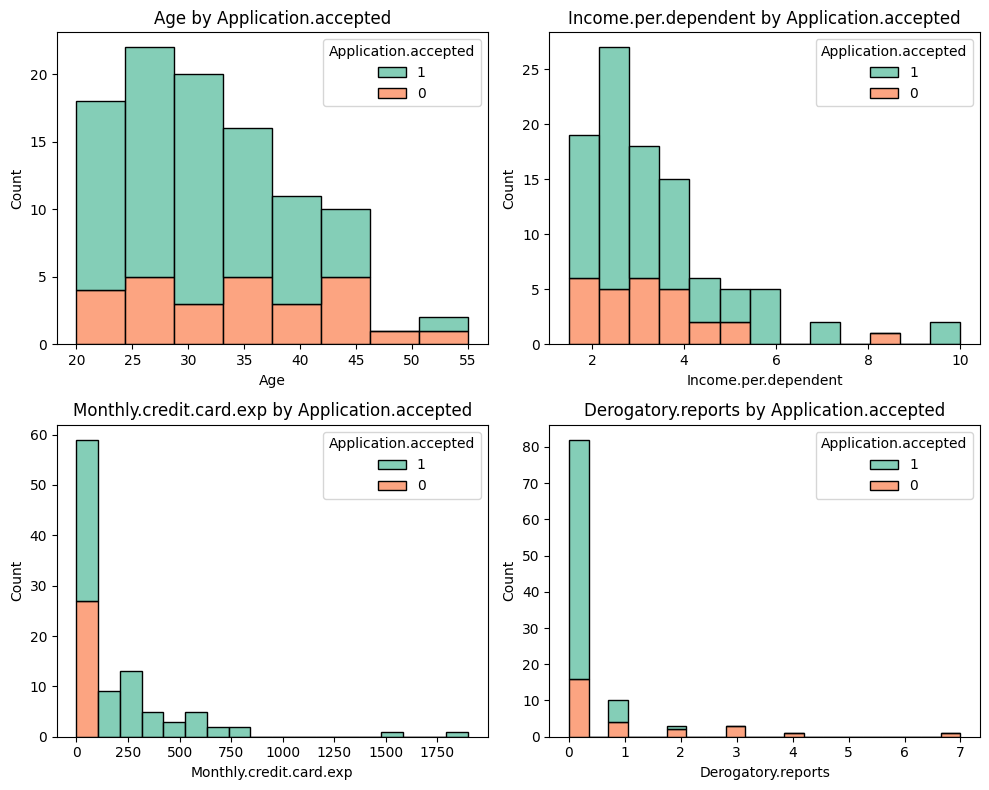

In [26]:
# Feature Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for col, ax in zip(numeric_cols, axes):
    sns.histplot(
        data=credit_score_df,
        x=col,
        hue='Application.accepted',      
        multiple='stack',         
        hue_order=[1, 0],        
        ax=ax,
        alpha=0.8,
    )
    ax.set_title(f"{col} by Application.accepted")

plt.tight_layout()
plt.show()

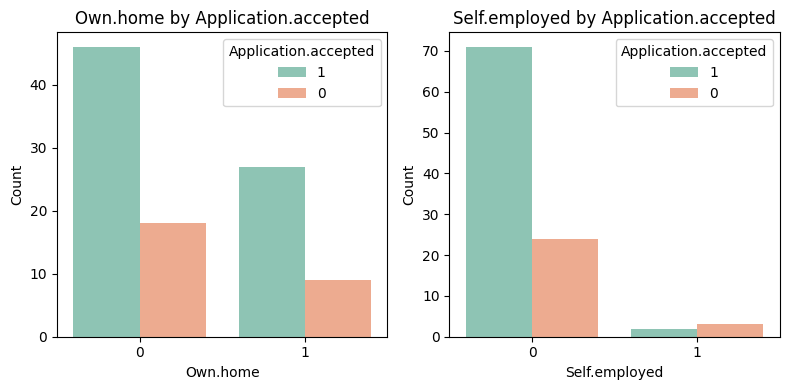

In [27]:
# Class Balance of Binary Features
fig, axes = plt.subplots(1, len(binary_cols), figsize=(8, 4))
axes = axes.flatten()

for col, ax in zip(binary_cols, axes):
    sns.countplot(
        data=credit_score_df,
        x=col,
        hue='Application.accepted',
        hue_order=[1, 0],  
        ax=ax,
        alpha=0.8, 
    )
    ax.set_title(f"{col} by Application.accepted")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend(title="Application.accepted")

plt.tight_layout()
plt.show()

### Outlier Detection using IQR

In [30]:
# Backup original data, calculate with copy
before = credit_score_df["Monthly.credit.card.exp"].copy()

raw_expenses = before.copy()

# IQR thresholds
Q1 = raw_expenses.quantile(0.25)
Q3 = raw_expenses.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Q1 = {Q1:.2f}")
print(f"Q3 = {Q3:.2f}")
print(f"IQR = {IQR:.2f}")
print(f"Upper limit = {upper_limit:.2f}")
print(f"Lower limit = {lower_limit:.2f}")

# Apply capping 
after = np.where(
    raw_expenses > upper_limit,
    upper_limit,
    np.where(raw_expenses < lower_limit, lower_limit, raw_expenses)
)

credit_score_df["Monthly.credit.card.exp"] = after

# Compare
num_changed = (before != after).sum()
print(f"\nNumber of values capped or adjusted: {num_changed}")

if num_changed > 0:
    print("\nChanged rows:")
    changed = credit_score_df.loc[before != after, ["Monthly.credit.card.exp"]]
    print(changed)

Q1 = 0.00
Q3 = 252.81
IQR = 252.81
Upper limit = 632.01
Lower limit = -379.21

Number of values capped or adjusted: 0


Skewedness

Skewed columns: ['Income.per.dependent', 'Monthly.credit.card.exp']
Income.per.dependent       1.881696
Monthly.credit.card.exp    1.220002
Age                        0.646500
dtype: float64

Income.per.dependent:
  Original skewness:   1.882
  Transformed skewness:0.800


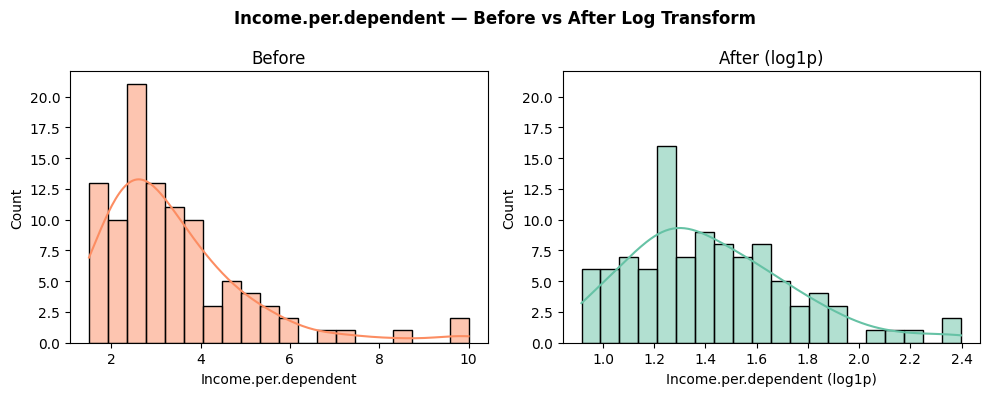


Monthly.credit.card.exp:
  Original skewness:   1.220
  Transformed skewness:-0.586


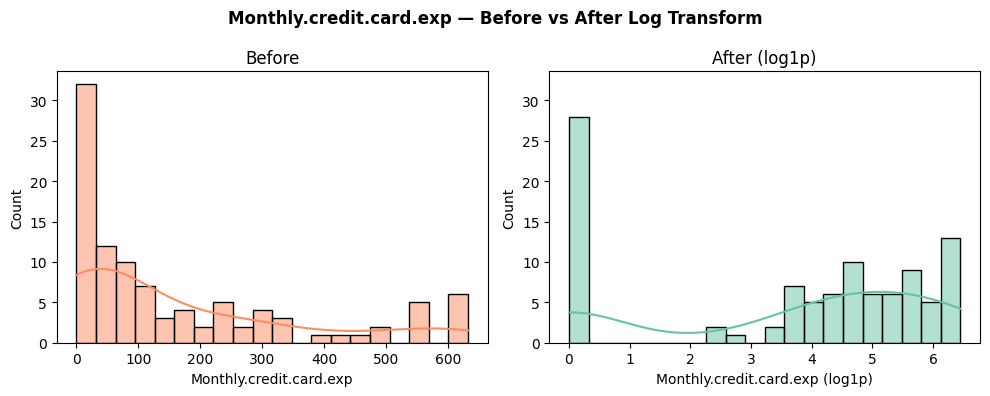

In [31]:
skewed = (
    credit_score_df[numeric_cols]
    .drop(columns="Derogatory.reports")
    .skew()
    .sort_values(ascending=False)
)
skewed_cols = skewed[skewed > 1].index.tolist()

print("Skewed columns:", skewed_cols)
print(skewed)

for col in skewed_cols:
    # Compute temporary log transform
    transformed = np.log1p(credit_score_df[col].clip(lower=0))
    
    # Compute skewness before & after
    original_skew = credit_score_df[col].skew()
    transformed_skew = transformed.skew()
    
    print(f"\n{col}:")
    print(f"  Original skewness:   {original_skew:.3f}")
    print(f"  Transformed skewness:{transformed_skew:.3f}")
    
    # Plot before vs after
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{col} — Before vs After Log Transform", fontsize=12, weight='bold')
    
    sns.histplot(
        credit_score_df[col], bins=20, kde=True,
        color=palette[1], edgecolor="black", ax=axes[0]
    )
    axes[0].set_title("Before")
    axes[0].set_xlabel(col)
    
    sns.histplot(
        transformed, bins=20, kde=True,
        color=palette[0], edgecolor="black", ax=axes[1]
    )
    axes[1].set_title("After (log1p)")
    axes[1].set_xlabel(f"{col} (log1p)")
    
    # Match y-axis
    ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

# Final cleanup 
credit_score_df = credit_score_df.replace([np.inf, -np.inf], np.nan).dropna()



In [ ]:
# Don't run more than once
for col in skewed_cols:
    credit_score_df[col] = np.log1p(credit_score_df[col].clip(lower=0))

credit_score_df.head()

,Age,Income.per.dependent,Monthly.credit.card.exp,Own.home,Self.employed,Derogatory.reports,Application.accepted
0,38.0,1.708378,4.836123,1,0,0,1
1,33.0,1.229641,2.384165,0,0,0,1
2,34.0,1.704748,2.772589,1,0,0,1
3,31.0,1.264127,4.933538,0,0,0,1
4,32.0,2.378620,6.305362,1,0,0,1


Scaling

In [34]:
scale_cols = ['Age', 'Income.per.dependent', 'Monthly.credit.card.exp']

scaler = RobustScaler()
credit_score_df[scale_cols] = scaler.fit_transform(credit_score_df[scale_cols])

print(credit_score_df[scale_cols].head())

        Age  Income.per.dependent  Monthly.credit.card.exp
0  0.636364              0.825878                 0.076952
1  0.181818             -0.401688                -0.365917
2  0.272727              0.816571                -0.295761
3  0.000000             -0.313259                 0.094547
4  0.090909              2.544495                 0.342324


Feature Importance

Additional visual analysis after first model trainings showed a dominent feature.

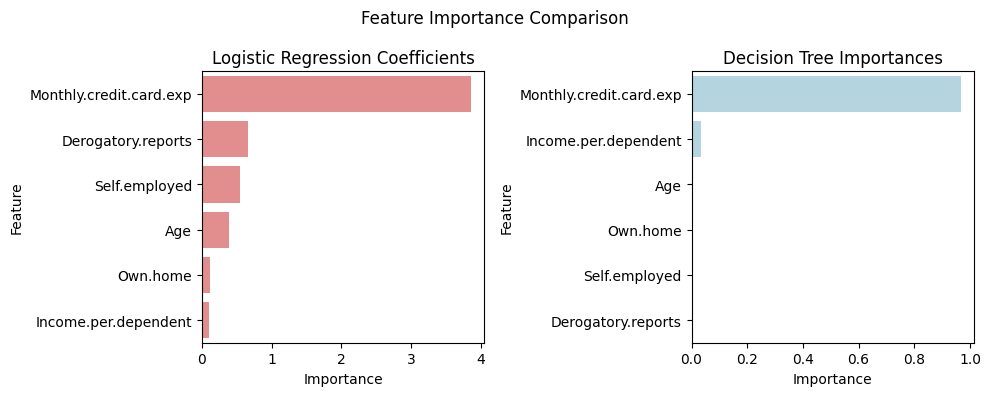

In [35]:
X = credit_score_df.drop(columns=["Application.accepted"])
y = credit_score_df["Application.accepted"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
logreg = LogisticRegression(class_weight="balanced", random_state=42)
logreg.fit(X_train, y_train)

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": abs(logreg.coef_[0])
}).sort_values(by="Importance", ascending=False)

# Decision Tree
tree = DecisionTreeClassifier(random_state=42, class_weight="balanced", max_depth=3)
tree.fit(X_train, y_train)

tree_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": tree.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Feature Importance Comparison")

sns.barplot(data=coef_df, x="Importance", y="Feature", ax=axes[0], color="lightcoral")
axes[0].set_title("Logistic Regression Coefficients")

sns.barplot(data=tree_df, x="Importance", y="Feature", ax=axes[1], color="lightblue")
axes[1].set_title("Decision Tree Importances")

plt.tight_layout()
plt.show()


### Logistic Regression

In [61]:
X = credit_score_df.drop(columns=["Application.accepted"])
y = credit_score_df["Application.accepted"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Model 1a 
model_logReg = LogisticRegression(random_state=42)
model_logReg.fit(X_train, y_train)
y_pred_logReg = model_logReg.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_logReg, digits=3))

# Model 1b: Class Weight
model_weighted = LogisticRegression(class_weight='balanced', random_state=42)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

print("=== Logistic Regression with Class Weights ===")
print(classification_report(y_test, y_pred_weighted, digits=3))

# Model 1c: Oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

model_resampled = LogisticRegression(random_state=42)
model_resampled.fit(X_res, y_res)
y_pred_resampled = model_resampled.predict(X_test)

print("\n=== Logistic Regression with Oversampling ===")
print(classification_report(y_test, y_pred_resampled, digits=3))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.800     0.800     0.800         5
           1      0.933     0.933     0.933        15

    accuracy                          0.900        20
   macro avg      0.867     0.867     0.867        20
weighted avg      0.900     0.900     0.900        20

=== Logistic Regression with Class Weights ===
              precision    recall  f1-score   support

           0      0.833     1.000     0.909         5
           1      1.000     0.933     0.966        15

    accuracy                          0.950        20
   macro avg      0.917     0.967     0.937        20
weighted avg      0.958     0.950     0.951        20


=== Logistic Regression with Oversampling ===
              precision    recall  f1-score   support

           0      0.833     1.000     0.909         5
           1      1.000     0.933     0.966        15

    accuracy                          0.950        20
   mac

Cross Validation: Model 1a, 1b, 1c

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Simple Logistic Regression
f1_scores = cross_val_score(model_logReg, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(model_logReg, X, y, cv=skf, scoring='accuracy')

print(f"Mean Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

# Weighted Logistic Regression
f1_scores = cross_val_score(model_weighted, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(model_weighted, X, y, cv=skf, scoring='accuracy')

print(f"Mean Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

# Oversampled Logistic Regression
f1_scores = cross_val_score(model_resampled, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(model_resampled, X, y, cv=skf, scoring='accuracy')

print(f"Mean Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Mean Accuracy: 0.980 ± 0.024
Mean F1 Score: 0.975 ± 0.031


Logistic Regression Boundary Plot

c:\Users\tanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


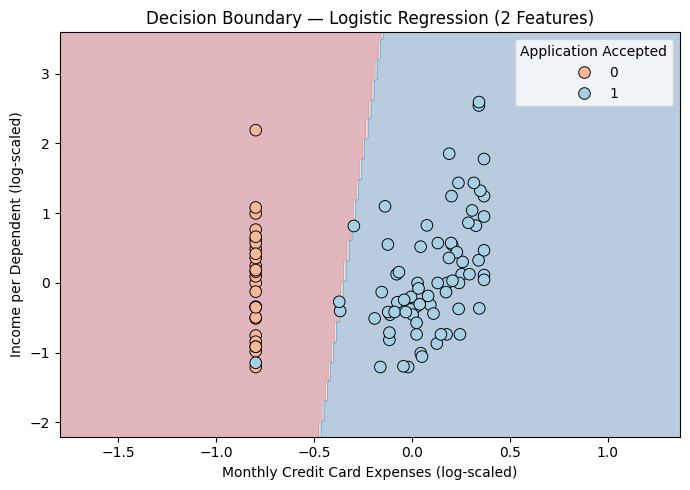

In [14]:
features = ['Monthly.credit.card.exp', 'Income.per.dependent']
X2 = X[features]

log_reg_2d = LogisticRegression(class_weight='balanced', solver='liblinear')
log_reg_2d.fit(X2, y)

# Plot decision boundary
x_min, x_max = X2[features[0]].min() - 1, X2[features[0]].max() + 1
y_min, y_max = X2[features[1]].min() - 1, X2[features[1]].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = log_reg_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
sns.scatterplot(
    x=features[0], y=features[1], hue=y,
    data=X2.join(y),
    palette='RdBu', edgecolor='k', s=70
)
plt.title("Decision Boundary — Logistic Regression (2 Features)", fontsize=12)
plt.xlabel("Monthly Credit Card Expenses (log-scaled)")
plt.ylabel("Income per Dependent (log-scaled)")
plt.legend(title="Application Accepted", loc='upper right')
plt.tight_layout()
plt.show()



### Decision Tree

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

print("=== Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_tree))




=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        15

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Cross Validation: Model 2

In [16]:
dt = DecisionTreeClassifier(
    criterion="gini",
    random_state=42
)

acc_scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
f1_scores = cross_val_score(dt, X, y, cv=5, scoring='f1_macro')

print(f"Mean Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Mean Accuracy: 0.980 ± 0.024
Mean F1 Score: 0.976 ± 0.029


### SVM

In [17]:
# Model 3a: Class Weights
svm_clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("=== Support Vector Machine with Class Weights ===")
print(classification_report(y_test, y_pred_svm))

# Model 3b: Oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

svm_clf_over = SVC(kernel='linear', random_state=42)
svm_clf_over.fit(X_res, y_res)
y_pred_svm_over = svm_clf_over.predict(X_test)

print("\n=== Support Vector Machine with Oversampling ===")
print(classification_report(y_test, y_pred_svm_over))


=== Support Vector Machine with Class Weights ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        15

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


=== Support Vector Machine with Oversampling ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        15

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Cross Validation: Models 3a and 3b

In [18]:
svm_cv = SVC(kernel='linear', class_weight='balanced', random_state=42)

acc_scores = cross_val_score(svm_cv, X, y, cv=5, scoring='accuracy')
f1_scores = cross_val_score(svm_cv, X, y, cv=5, scoring='f1_macro')

print(f"Mean Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")


Mean Accuracy: 0.990 ± 0.020
Mean F1 Score: 0.989 ± 0.023


SVM Plot

Evaluation Function

In [ ]:
from evaluater import evaluate_model

log_reg_results = evaluate_model(
    LogisticRegression(class_weight='balanced', random_state=42),
    X_train, X_test, y_train, y_test,
    model_name="Logistic Regression"
)

SyntaxError: invalid syntax (1806368679.py, line 1)

5. Efficiency Metrics (Optional)

In [ ]:
import time
start = time.time()
model.fit(X_train, y_train)
runtime = time.time() - start



=== Logistic Regression ===
Holdout Accuracy: 1.000, F1: 1.000
CV Accuracy: 0.988 ± 0.025
CV F1: 0.985 ± 0.031
Runtime: 0.01s


NameError: name 'results_table' is not defined

In [49]:
#df_credit.groupby("Application.accepted").mean()

In [50]:
#df_credit.groupby("Application.accepted")[["Monthly.credit.card.exp", "Derogatory.reports"]].describe()

### Holdout vs Cross-Validation

- Pay attention to your splits and settings
Are there differences? Why? In which metrics? What could have caused it?
- Compare/document changes in runtime behaviour with the changing e.g. dataset size